In [26]:
import numpy as np


# 软阈值算子
def soft_thresholding_operator(x, lambda_):
    """
    实现软阈值算子
    :param x: 输入向量或标量
    :param lambda_: 阈值参数
    :return: 软阈值处理后的结果
    """
    return np.sign(x) * np.maximum(0, np.abs(x) - lambda_)


# KKT停机准则
def check_kkt(x, A, b, lambda_):
    """验证Lasso问题的解是否满足KKT条件"""
    y = x + A.T @ (b - A @ x)
    return np.linalg.norm(soft_thresholding_operator(y, lambda_) - x, ord=2) / (1 + np.linalg.norm(x, ord=2))


# 近端梯度下降法求解Lasso回归问题

In [27]:
def pgd_lasso(A, b, lambda_, max_iter=1000, tol=1e-5):
    """
    使用近端梯度下降法求解Lasso回归问题
    :param A: 特征矩阵
    :param b: 目标向量
    :param lambda_: L1正则化参数
    :param max_iter: 最大迭代次数
    :param tol: 收敛容限
    :return: 求解得到的权重向量x
    """
    # 初始化beta为零向量
    x = np.zeros(A.shape[1])

    # 计算梯度的Lipschitz常数
    L = np.linalg.norm(A.T @ A)

    res = []
    # 迭代更新参数x
    for _ in range(max_iter):
        # 计算梯度
        gradient = A.T @ (A @ x - b)

        # 近端梯度更新
        x_new = soft_thresholding_operator(x - gradient / L, lambda_ / L)

        # 检查收敛性
        res.append(check_kkt(x_new, A, b, lambda_))
        if res[-1] <= tol:
            return x_new, res

        x = x_new

    return x, res

# 加速近端梯度下降法求解Lasso回归问题

In [28]:
def apg_lasso(A, b, lambda_, max_iter=1000, tol=1e-5):
    """
    使用加速近端梯度下降法（APG/FISTA）求解Lasso回归问题
    :param A: 特征矩阵
    :param b: 目标向量
    :param lambda_: L1正则化参数
    :param max_iter: 最大迭代次数
    :param tol: 收敛容限
    :return: 求解得到的权重向量x
    """
    m, n = A.shape
    # 初始化
    x = np.zeros(n)
    x_old = np.zeros(n)

    # 计算梯度的Lipschitz常数
    L = np.linalg.norm(A.T @ A)

    res = []
    for i in range(max_iter):
        # 更新动量
        v = x_old + (i - 2) * (x - x_old) / (i + 1)
        # 近端梯度更新
        gradient = A.T @ (A @ x - b)
        x_new = soft_thresholding_operator(v - gradient / L, lambda_ / L)

        res.append(check_kkt(x_new, A, b, lambda_))
        if res[-1] <= tol:
            return x_new, res
        x_old = x
        x = x_new
    return x, res

In [29]:
# 数据生成
np.random.seed(0)
n_samples, n_features = 100, 10
matrixA = np.random.randn(n_samples, n_features)
true_coef = 3 * np.random.randn(n_features)
# 将系数向量中的大部分元素设置为零，以模拟稀疏性
true_coef[abs(true_coef) < 1] = 0
b = np.dot(matrixA, true_coef) + np.random.normal(size=n_samples)

In [32]:
print(true_coef)

[ 1.66788804  2.67742166 -1.26694447  0.          0.          0.
  1.62232076 -5.45423289  0.          0.        ]


[ 1.71499648  2.61431173 -1.29190701  0.01910972  0.05663686  0.06575032
  1.61186708 -5.47513283 -0.09482837  0.04347951]


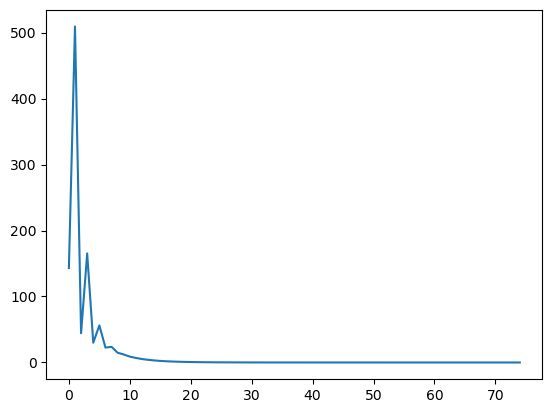

In [37]:
from matplotlib import pyplot as plt

x,res = apg_lasso(matrixA, b, 0.1)
print(x)
plt.plot(res)